# ResNet50

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten # Layers to construct NN
from keras.models import Model # Here "Model" is a class to define arct. of NN model 
from tensorflow.keras.applications.resnet50 import ResNet50 # Importing pre-trainied CNN acrt from Keras
from tensorflow.keras.applications.resnet50 import preprocess_input # "preprocess_input" is a function taken from Keras
from keras.preprocessing import image # "image" is a class for loading & processing img data & testing CNN
from keras.preprocessing.image import ImageDataGenerator # for data augmentation and "ImageDataGenerator" is a class for loading & processing img data & testing CNN
from keras.models import Sequential # "Sequential" is a class used for linear stack of layers in NN
import numpy as np # NUmPy library 
from glob import glob
import matplotlib.pyplot as plt # For creating visualization 
import os # Interact with operating systemproviding a way to interact with files and directories.
import cv2 #Phyton library for vision tasks. 
import tensorflow as tf
from keras.layers import Dropout
from keras.optimizers import Adam

Re-size all the images to this

In [2]:
IMAGE_SIZE = [224, 224] # Taken 224x224 because Imagenet size and from keras we know that 224x224 is the default size for ResNet50

In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/try/Data/train' #Train
valid_path = '/content/drive/MyDrive/Colab Notebooks/try/Data/test' #Test

Sample Images

In [4]:
image_paths = ['/content/drive/MyDrive/Colab Notebooks/try/Data/test/squamous.cell.carcinoma','/content/drive/MyDrive/Colab Notebooks/try/Data/test/normal','/content/drive/MyDrive/Colab Notebooks/try/Data/test/large.cell.carcinoma','/content/drive/MyDrive/Colab Notebooks/try/Data/test/adenocarcinoma']

def load_images(image_paths = image_paths, n=36): # n=36 means 36 images will be shown here, image_paths means a list of file paths where the images are stored
    # Load the images from disk.
    images = [] # this initializes an empty list called images. The purpose of this is to store the images, that will be loaded from disk.
    for i in range(len(image_paths)):
        images_ = [cv2.imread(image_paths[i]+'/'+path) for path in os.listdir(image_paths[i])[:int(n/4)]] #
        images.append(images_)
    # this for loop 
    # Convert to a numpy array and return it.
    sample = np.asarray(images)
    return sample

<ipython-input-4-39cf8abb7dda>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.asarray(images)


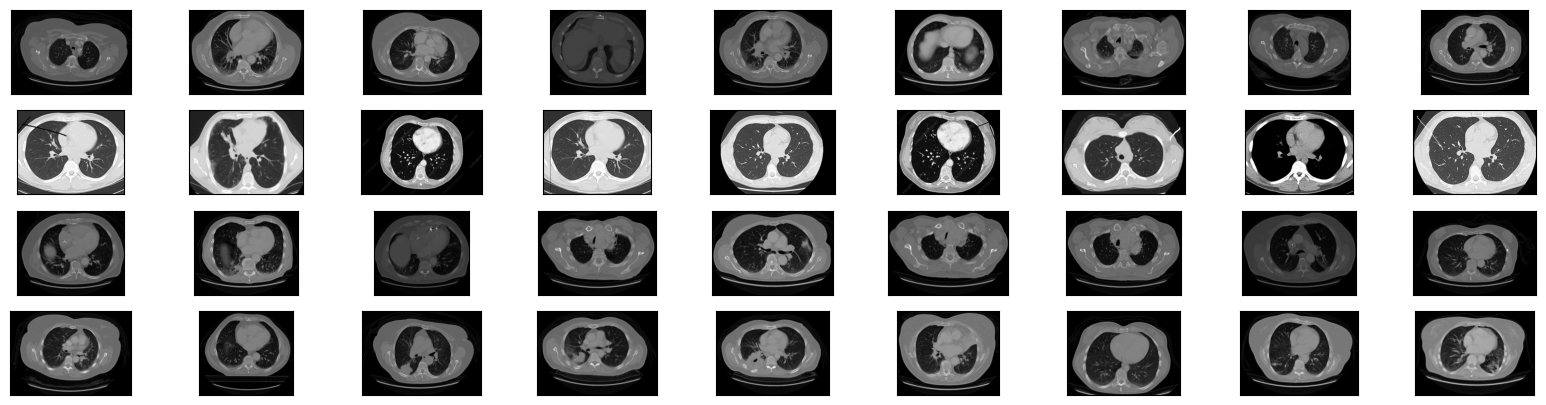

In [5]:
sample = load_images()
fig = plt.figure(figsize=(20,5)) # 20"x 5" plotting size is 20x5inch
l = 1 
shapes = [224,224,1] #3D array, 224 is the width and height and 1 is color channel which is black and white
#For showing the sample images, i used loop
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = []) # 4 rows and here is 9 columns, m+l here is subplot
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9 # each row will show 9 images 

Import ResNet50 library as shown.

Add preprocessing layer to the front of ResNet

In [6]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 2s 0us/step


Don't train existing weights because transfer learning

In [7]:
for layer in resnet.layers:
  layer.trainable = False

Useful for getting number of classes

In [8]:
folders = glob('/content/drive/MyDrive/Colab Notebooks/try/Data/train/*')

Layers

In [10]:
#x = Flatten()(resnet.output) #Convert to 1D
# x = Dense(1000, activation='relu')(x)
inputs = resnet.output  # ResNet50 is the base model
flatten = Flatten()(inputs)
dropout = Dropout(0.2)(flatten)  # Add Dropout layer
prediction = Dense(len(folders), activation='softmax')(dropout)
#prediction = Dense(len(folders), activation='softmax')(x) # Fully connected layer with a softmax activation function. 

Create a model object

In [11]:
model = Model(inputs=resnet.input, outputs=prediction) #creates a new model called model that takes the input from the pre-trained ResNet model and passes it through the prediction layer to produce the output.
#This model includes both the pre-trained layers of ResNet and the new prediction layer and will be trained on the dataset to perform image classification

Viewing Structure of the model

In [13]:
learning_rate = 0.001

model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate= learning_rate), #Optimizer
  metrics=['accuracy']
)

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

Cost and optimization

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True)

In [17]:
test_datagen = ImageDataGenerator(rescale = 1./255)

Check how many images and how many classes for training 

In [18]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/try/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 613 images belonging to 4 classes.


Check how many images and how many classes for testing 

In [19]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/try/Data/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 315 images belonging to 4 classes.


Fit the model

In [20]:
r = model.fit_generator(
  training_set,
 # validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-20-fdaf5df8d5d7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
20/20 [==============================] - 120s 5s/step - loss: 4.9818 - accuracy: 0.3866
Epoch 2/5
20/20 [==============================] - 10s 511ms/step - loss: 2.1823 - accuracy: 0.5041
Epoch 3/5
20/20 [==============================] - 11s 515ms/step - loss: 1.4061 - accuracy: 0.5008
Epoch 4/5
20/20 [==============================] - 11s 524ms/step - loss: 1.2346 - accuracy: 0.5628
Epoch 5/5
20/20 [==============================] - 10s 481ms/step - loss: 1.1633 - accuracy: 0.5579


In [21]:
Stest_lebels = test_set.labels

In [22]:
test_set.image_shape

(224, 224, 3)

In [23]:
results = model.evaluate(test_set)

10/10 [==============================] - 38s 4s/step - loss: 1.5770 - accuracy: 0.4571


In [24]:
from keras.models import load_model

In [25]:
model.save('ResNet50LungCancer.h5')